✅ scikit-learn version: 1.5.1
🔍 Total files found: 2834
📦 Feature matrix shape: (2834, 4), Target shape: (2834,)
🎯 Mean Squared Error: 0.000001
🎯 R^2 Score: 0.9959


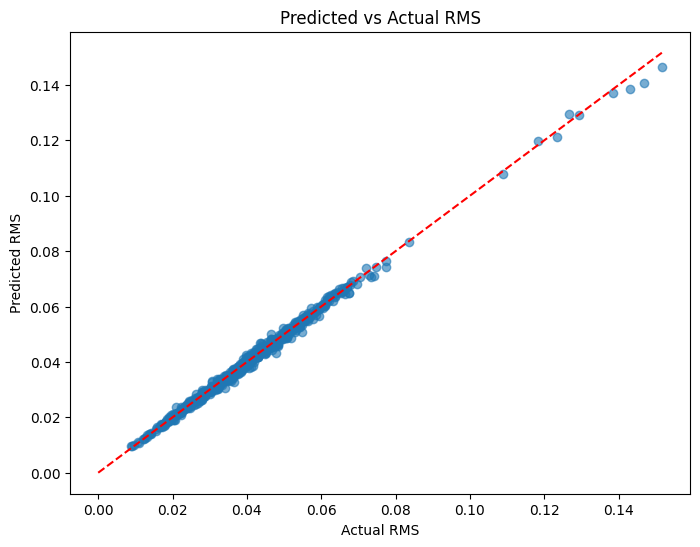

🎯 Accuracy: 0.9894
📊 Classification Report:
               precision    recall  f1-score   support

         Low       0.94      0.94      0.94        53
  Acceptable       0.99      0.99      0.99       514

    accuracy                           0.99       567
   macro avg       0.97      0.97      0.97       567
weighted avg       0.99      0.99      0.99       567



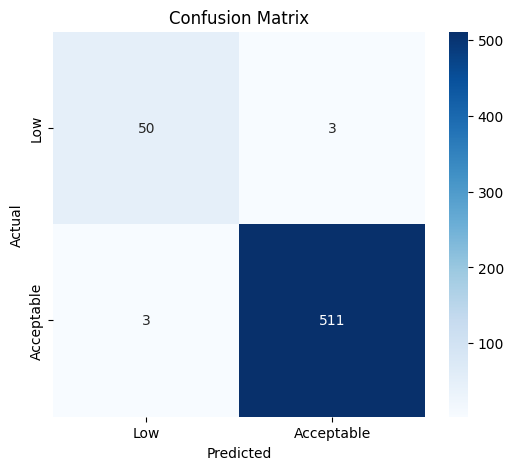

✅ Model saved to models/loudness_model.pkl


In [3]:
import os
import numpy as np
import joblib
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

import sklearn
print("✅ scikit-learn version:", sklearn.__version__)

# --- Feature extraction ---
def extract_features(path):
    y, sr = librosa.load(path, sr=None)
    
    # RMS (target)
    rms = np.mean(librosa.feature.rms(y=y))
    
    # Features (exclude RMS)
    peak = np.max(np.abs(y))
    lufs = 20 * np.log10(np.mean(np.abs(y)) + 1e-6)  # rough LUFS approximation
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
    return [peak, lufs, zcr, centroid], rms

# --- Load audio files ---
data_path = "data"
file_paths = [os.path.join(root, f)
              for root, _, files in os.walk(data_path)
              for f in files if f.endswith(".flac")]

print(f"🔍 Total files found: {len(file_paths)}")

X_list, y_list = [], []

for path in file_paths:
    try:
        features, rms = extract_features(path)
        X_list.append(features)
        y_list.append(rms)
    except Exception as e:
        print(f"⚠️ Error with {path}: {e}")

X = np.array(X_list)
y = np.array(y_list)

print(f"📦 Feature matrix shape: {X.shape}, Target shape: {y.shape}")

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- Evaluate regression ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"🎯 Mean Squared Error: {mse:.6f}")
print(f"🎯 R^2 Score: {r2:.4f}")

# --- Plot prediction vs actual ---
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual RMS")
plt.ylabel("Predicted RMS")
plt.title("Predicted vs Actual RMS")
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.show()

# --- Convert regression to categories for classification metrics ---
# Define thresholds
def rms_to_category(rms_value):
    if rms_value < 0.02:
        return 1  # Low
    else:
        return 2  # Acceptable

y_test_cat = np.array([rms_to_category(v) for v in y_test])
y_pred_cat = np.array([rms_to_category(v) for v in y_pred])

# --- Classification metrics ---
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_cat, y_pred_cat)
print(f"🎯 Accuracy: {acc:.4f}")
print("📊 Classification Report:\n", classification_report(y_test_cat, y_pred_cat, target_names=['Low', 'Acceptable']))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_cat, y_pred_cat)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Acceptable'], yticklabels=['Low', 'Acceptable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# --- Save model ---
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/loudness_model.pkl")
print("✅ Model saved to models/loudness_model.pkl")
